In [1]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [2]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

8

In [184]:
BATCH_SIZE = 256

## Dataset pipline

In [185]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Create a TensorFlow data pipeline for the training set
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(buffer_size=5000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

# Create a TensorFlow data pipeline for the test set.
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    .as_numpy_iterator())

def get_batch(training: bool = True):
  images, labels = (
      next(train_dataset) if training
      else next(test_dataset))

  images, labels = jnp.array(images), jnp.array(labels)
  images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

### test get_batch

In [186]:
test_images, test_labels = get_batch()
test_images.shape, test_labels.shape

((256, 784), (256, 10))

In [187]:
test_image, test_label = test_images[0], test_labels[0]
test_image.shape

(784,)

## Modeling

In [188]:
class Autoencoder(nn.Module):
    @nn.compact
    def __call__(self, x, training=False):
        x = jnp.reshape(x, (28, 28, 1))

        # encoder
        x = nn.Conv(16, (3, 3), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(32, (3, 3), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.Conv(64, (3, 3), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = jnp.reshape(x, (-1)) # flatten
        x = nn.Dense(3136)(x) # project to flat dimension of 3136, so that you can reconstruct 7x7x64 image from that by reshape

        # decoder
        x = jnp.reshape(x, (7, 7, 64))
        x = nn.ConvTranspose(32, (3, 3), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        x = nn.ConvTranspose(1, (3, 3), strides=(2, 2), padding="SAME")(x)
        x = nn.relu(x)
        return x

In [189]:
class TrainState(train_state.TrainState):
  key: jax.random.KeyArray

random_key = jax.random.PRNGKey(99)
random_key, random_subkey = jax.random.split(random_key)

model = Autoencoder()

output, params = model.init_with_output(jrand.PRNGKey(99), test_image, training=False)
params = params["params"]

In [201]:
def model_apply(params, inputs):
  return model.apply({"params": params}, inputs, False)

model_apply_batch = jax.vmap(model_apply, in_axes=(None, 0), out_axes=(0))

def forward_pass(params, state, batch):
  inputs, _ = batch # you are using reconstruction loss, so NO need of targets.
  reconstructed = state.apply_fn(params, inputs)

  PER_HOST_BATCH_SIZE = BATCH_SIZE // jax.device_count()

  reconstructed = jnp.reshape(reconstructed, (PER_HOST_BATCH_SIZE, -1)) # flatten the reconstructed to (32, 784)

  chex.assert_shape(inputs, (PER_HOST_BATCH_SIZE, 784))
  chex.assert_shape(reconstructed, (PER_HOST_BATCH_SIZE, 784))

  loss = (inputs - reconstructed) ** 2
  loss = loss.mean()
  return loss

def train_step(state, inputs, targets):
  batch = inputs, targets
  grad_fn = jax.value_and_grad(forward_pass, argnums=(0))  # differentiate wrt 0th pos argument.
  loss, grads = grad_fn(state.params, state, batch)

  loss = jax.lax.pmean(loss, axis_name="devices")
  grads = jax.lax.pmean(grads, axis_name="devices")

  state = state.apply_gradients(grads=grads)
  return state, loss

opt = optax.adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model_apply_batch, params=params, tx=opt, key=random_key)

In [202]:
# pmap the train_step.
train_step_pmap = jax.pmap(train_step, in_axes=(0, 0, 0), out_axes=(0), axis_name="devices")

In [203]:
# replicate state
states = jax.device_put_replicated(state, jax.local_devices())

In [209]:
for epoch in range(5000):
  inputs, targets = get_batch()

  # create device dimension for minibatch
  inputs = inputs.reshape((jax.device_count(), -1, inputs.shape[-1]))
  targets = targets.reshape((jax.device_count(), -1, targets.shape[-1]))

  states, loss = train_step_pmap(states, inputs, targets)
  print("loss", loss[0], "epoch", epoch) if epoch%100==0 else None

loss 0.00048067715 epoch 0
loss 0.000505811 epoch 100
loss 0.00046706392 epoch 200
loss 0.00048119578 epoch 300
loss 0.0004230609 epoch 400
loss 0.0004773473 epoch 500
loss 0.00041368007 epoch 600
loss 0.00041442967 epoch 700
loss 0.00036703786 epoch 800
loss 0.0003926286 epoch 900
loss 0.00039857323 epoch 1000
loss 0.0003773875 epoch 1100
loss 0.00037977213 epoch 1200
loss 0.00038504828 epoch 1300
loss 0.00035094918 epoch 1400
loss 0.00038252055 epoch 1500
loss 0.0003485326 epoch 1600
loss 0.00034126657 epoch 1700
loss 0.0003434678 epoch 1800
loss 0.00034516718 epoch 1900
loss 0.00033134886 epoch 2000
loss 0.00035278755 epoch 2100
loss 0.0003077766 epoch 2200
loss 0.00031995762 epoch 2300
loss 0.00031685247 epoch 2400
loss 0.00031115848 epoch 2500
loss 0.00031665235 epoch 2600
loss 0.00029483414 epoch 2700
loss 0.0003117331 epoch 2800
loss 0.00027640339 epoch 2900
loss 0.0002959827 epoch 3000
loss 0.0002718885 epoch 3100
loss 0.00026830027 epoch 3200
loss 0.00023316266 epoch 3300
loss

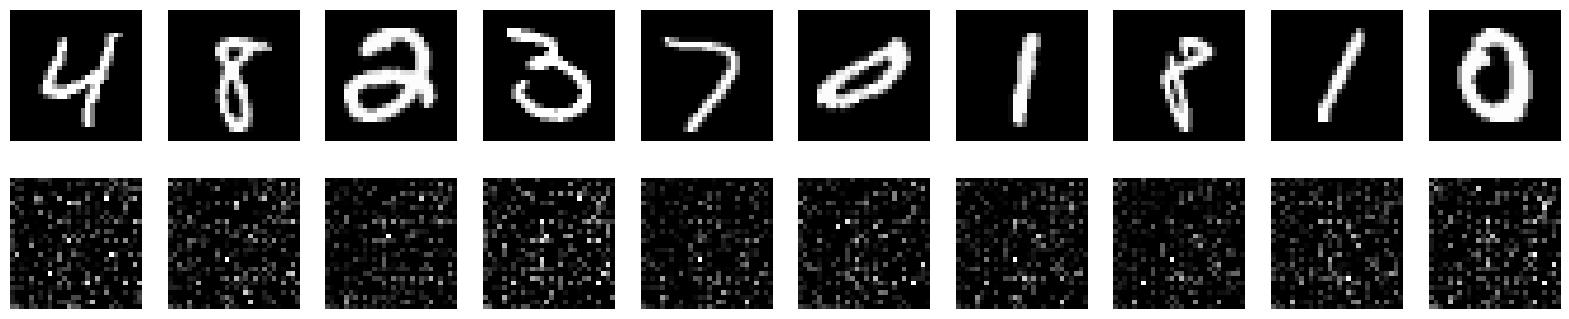

In [210]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = model_apply_batch(params, inputs)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructions
plot_reconstructions(model, params, get_batch())
